In [16]:
import pandas as pd
import yfinance as yf

import openai
import pandas as pd
from dotenv import load_dotenv
import os
import tqdm

import time

In [6]:
choices = [15, 30, 45, 60]

In [ ]:
dotenv_path = os.path.join(os.path.dirname(os.getcwd()), '.env')
load_dotenv(dotenv_path)

def get_chatgpt_tickers(n):
    client = openai.OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
    message = f"Using a range of investing principles taken from leading funds, create a theoretical fund comprising of at least {n} stocks (mention their tickers) from the S&P500 with the goal to outperform the S&P500 index. Return as a list that can be parsed in python."
    
    response = client.chat.completions.create(
        model="gpt-4.1",
        messages=[{"role": "user", "content": message}]
    )
    
    return response.choices[0].message.content

# Loop through each value and make 10 requests
with open(os.path.join("..", "data/chatgpt_tickers.txt"), "w") as f:
    for n in choices:
        for i in range(10):
            result = get_chatgpt_tickers(n)
            f.write(f"\n=== N={n} | Request {i+1} ===\n")
            f.write(result + "\n")
            print(f"[✔] Saved N={n}, Request {i+1}")
            time.sleep(1) 

[✔] Saved N=15, Request 1
[✔] Saved N=15, Request 2
[✔] Saved N=15, Request 3
[✔] Saved N=15, Request 4
[✔] Saved N=15, Request 5
[✔] Saved N=15, Request 6
[✔] Saved N=15, Request 7
[✔] Saved N=15, Request 8
[✔] Saved N=15, Request 9
[✔] Saved N=15, Request 10
[✔] Saved N=30, Request 1
[✔] Saved N=30, Request 2
[✔] Saved N=30, Request 3
[✔] Saved N=30, Request 4
[✔] Saved N=30, Request 5
[✔] Saved N=30, Request 6
[✔] Saved N=30, Request 7
[✔] Saved N=30, Request 8
[✔] Saved N=30, Request 9
[✔] Saved N=30, Request 10
[✔] Saved N=45, Request 1
[✔] Saved N=45, Request 2
[✔] Saved N=45, Request 3
[✔] Saved N=45, Request 4
[✔] Saved N=45, Request 5
[✔] Saved N=45, Request 6
[✔] Saved N=45, Request 7
[✔] Saved N=45, Request 8
[✔] Saved N=45, Request 9
[✔] Saved N=45, Request 10
[✔] Saved N=60, Request 1
[✔] Saved N=60, Request 2
[✔] Saved N=60, Request 3
[✔] Saved N=60, Request 4
[✔] Saved N=60, Request 5
[✔] Saved N=60, Request 6
[✔] Saved N=60, Request 7
[✔] Saved N=60, Request 8
[✔] Saved

In [3]:
import ast

def extract_all_ticker_lists(filepath):
    request_blocks = {}
    current_key = None
    inside_list = False
    buffer = []

    with open(filepath, "r") as f:
        for line in f:
            line = line.strip()

            # Detect a request header line
            if line.startswith("==="):
                current_key = line.strip("= ").strip()
                inside_list = False
                buffer = []
                continue

            # Detect any opening of a list
            if "[" in line and not inside_list and current_key:
                inside_list = True
                buffer = [line[line.find("["):]]  # keep only from the first `[`
                continue

            # Collect lines until the list is closed
            if inside_list:
                buffer.append(line)
                if "]" in line:
                    inside_list = False
                    try:
                        full_text = "\n".join(buffer)
                        tickers = ast.literal_eval(full_text)
                        request_blocks[current_key] = tickers
                    except Exception as e:
                        print(f"⚠️ Failed to parse tickers for {current_key}: {e}")
                        print("Block was:\n", full_text)
                    buffer = []

    return request_blocks

data = extract_all_ticker_lists(os.path.join("..", "data/chatgpt_tickers.txt"))

In [4]:
df = pd.DataFrame([
    {
        "request": k,
        "n": int(k.split("|")[0].split("=")[1].strip()),
        "tickers": v,
        "count": len(v)
    }
    for k, v in data.items()
])

df_exploded = df.explode("tickers").rename(columns={"tickers": "ticker"})

# Preview
print(df.head())
print(df_exploded["ticker"].value_counts().head(10))

            request   n                                            tickers  \
0  N=15 | Request 1  15  [AAPL, MSFT, GOOGL, V, UNH, NVDA, AVGO, MA, LM...   
1  N=15 | Request 2  15  [MSFT, AAPL, NVDA, GOOGL, AMZN, V, JPM, LIN, U...   
2  N=15 | Request 3  15  [AAPL, MSFT, NVDA, GOOGL, AMZN, V, UNH, MA, CO...   
3  N=15 | Request 4  15  [MSFT, NVDA, AAPL, GOOGL, AMZN, LLY, UNH, META...   
4  N=15 | Request 5  15  [AAPL, MSFT, NVDA, GOOGL, AMZN, LLY, AVGO, V, ...   

   count  
0     15  
1     18  
2     15  
3     15  
4     15  
ticker
AAPL     39
UNH      39
COST     39
NVDA     39
MSFT     39
GOOGL    39
AMZN     37
AVGO     37
META     35
V        35
Name: count, dtype: int64


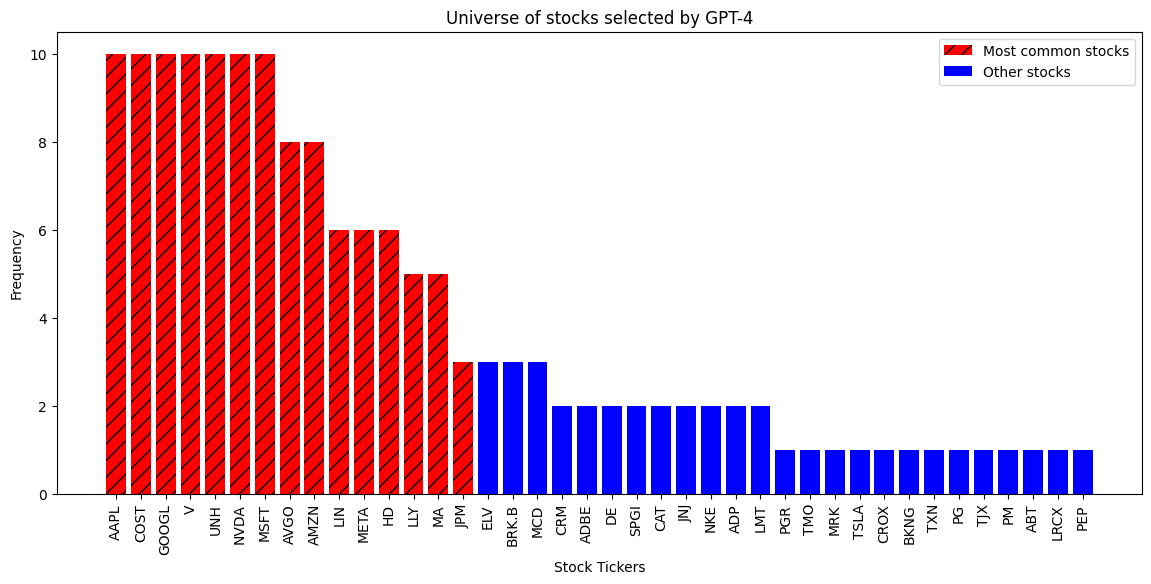

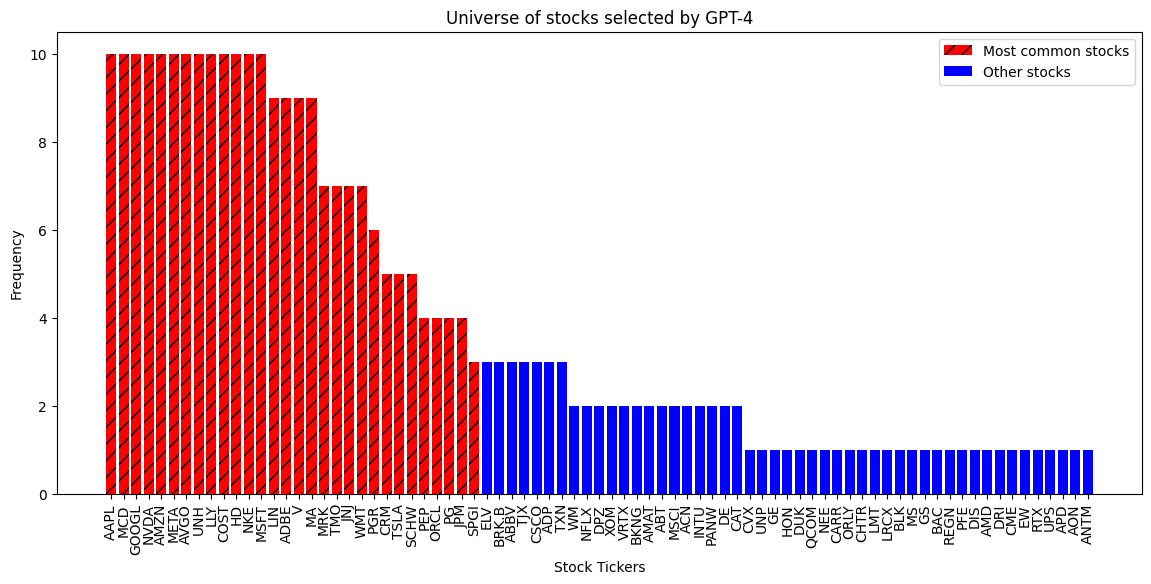

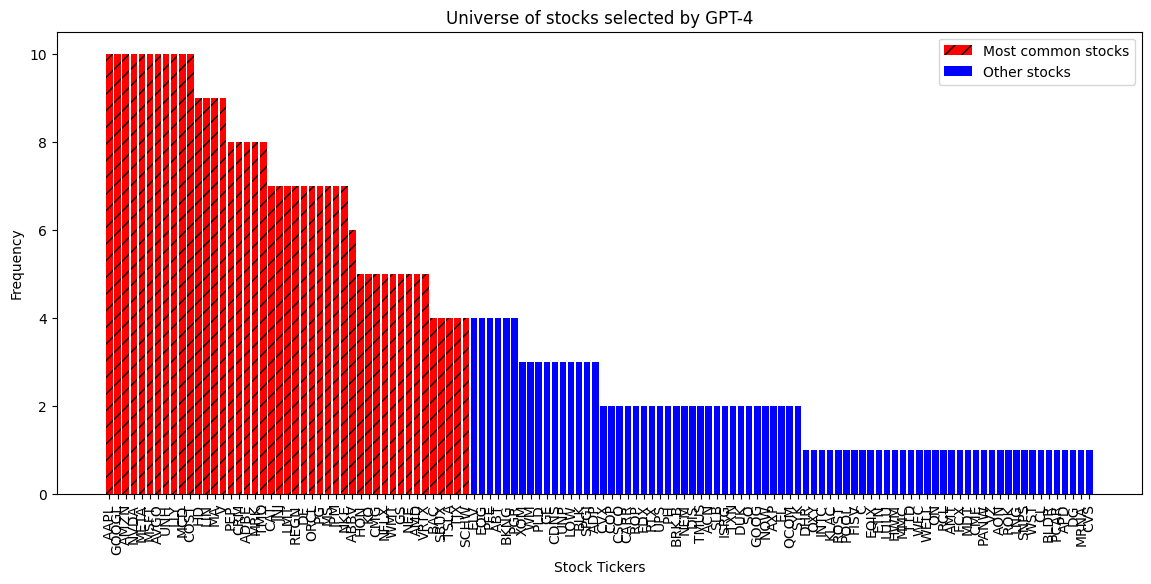

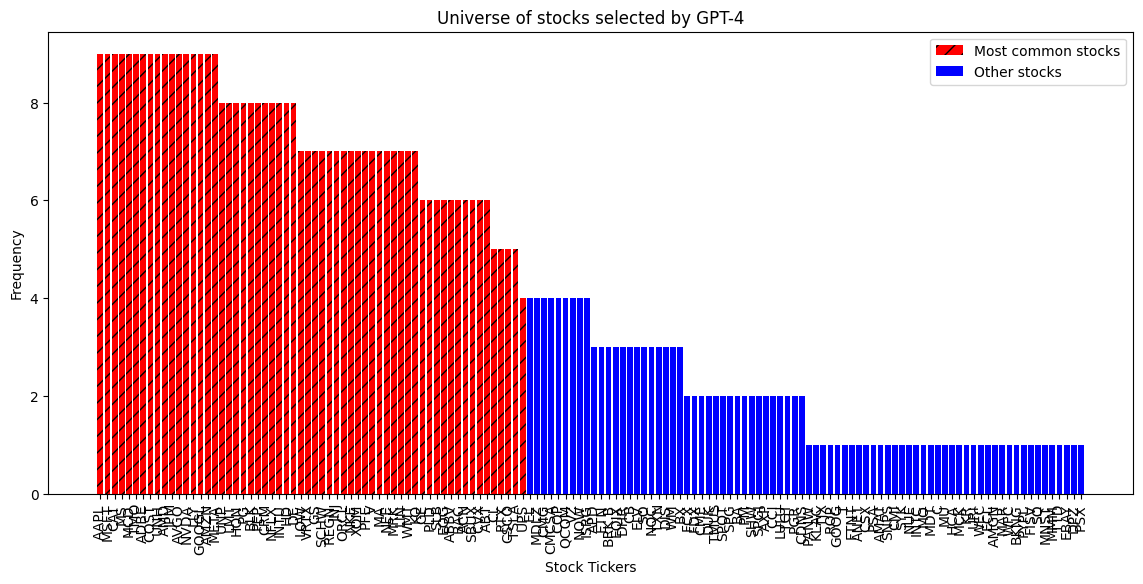

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

for i in choices:
    # Assume df_exploded is your exploded DataFrame with 'ticker' column
    df = df_exploded[df_exploded["n"] == i]
    ticker_counts = df['ticker'].value_counts()

    # Customize top N
    top_n = i
    top_tickers = ticker_counts.head(top_n)
    other_tickers = ticker_counts.iloc[top_n:]

    # Plot
    plt.figure(figsize=(14, 6))

    # Red bars for top tickers
    plt.bar(top_tickers.index, top_tickers.values, color='red', hatch='//', label='Most common stocks')

    # Blue bars for others
    plt.bar(other_tickers.index, other_tickers.values, color='blue', label='Other stocks')

    plt.xticks(rotation=90)
    plt.xlabel("Stock Tickers")
    plt.ylabel("Frequency")
    plt.legend()
    plt.title("Universe of stocks selected by GPT-4")

    # Add LaTeX-style figure caption
    # plt.figtext(0.5, -0.1, f"Universe of {i} stocks selected by GPT-4", ha='center', fontsize=12)

    plt.savefig(os.path.join('..',f"figs/top_{i}.png"))

In [14]:
def generate_chatgpt_insight(ticker):
    """Generate a prompt and request from OpenAI about the sentiment of a given company."""

    client = openai.OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

    prompt = (
        f"Given the following stock {ticker}, "
        "please write a report on the current state of the company. "
        "Please be clear on when you collected the most recent data. "
        "What are the key insights of each company? "
        "Please highlight the positives and negatives in an objective way for fair sentiment analysis."
        "Include any information from their financial reports or news."
    )
    try:
        response = client.chat.completions.create(
            model="gpt-4.1",
            messages=[{"role": "user", "content": prompt}]
        )
        return response.choices[0].message.content
    except Exception as e:
        return f"Error: {str(e)}"

In [18]:
def process_top_stocks(df, top_values=[15, 30, 45, 60], output_dir="sentiment"):
    """Process top X stocks for each choice and save insights to text files."""
    # Ensure output directory exists
    os.makedirs(f"../data/{output_dir}", exist_ok=True)

    # Collect all top stocks across the specified top values
    unique_stocks = set()
    for top_x in top_values:
        # Get top X stocks for each choice and add to the set
        top_stocks = df.groupby("request")["ticker"].value_counts().groupby(level=0).nlargest(top_x).reset_index(level=0, drop=True)
        unique_stocks.update(top_stocks.index.get_level_values(1))
    
    # Generate insights for each unique stock
    for ticker in tqdm.tqdm(unique_stocks, desc="Generating Insights"):
        file_path = os.path.join(f"../data/{output_dir}", f"{ticker}.txt")
        
        # Check if file already exists to avoid duplicate requests
        if os.path.exists(file_path):
            continue
        
        try:
            insight = generate_chatgpt_insight(ticker)
        except Exception as e:
            insight = f"Error generating insight: {str(e)}"
        
        # Save the insight to the file
        with open(file_path, "w") as file:
            file.write(f"Ticker: {ticker}\n")
            file.write(f"Insight:\n{insight}\n")
    
    print(f"Insights saved in the '{output_dir}' directory.")

process_top_stocks(df_exploded, top_values=[15, 30, 45, 60])

Generating Insights: 100%|██████████| 168/168 [54:09<00:00, 19.34s/it]

Insights saved in the 'sentiment' directory.


In [ ]:
def download_stock_data(ticker, output_dir="market", retries=5):
    file_path = os.path.join(f"../data/{output_dir}", f"{ticker}.csv")
    if os.path.exists(file_path):
        return f"{ticker} - Already downloaded."

    attempt = 0
    while attempt < retries:
        try:
            data = yf.download(ticker, start="2010-01-01", end="2025-01-01")
            if data.empty:
                return f"{ticker} - No data available."
            
            # Save the data to file
            data.to_csv(file_path)
            return f"{ticker} - Downloaded successfully."
        
        except yf.YFRateLimitError:
            attempt += 1
            wait_time = 2 ** attempt  # Exponential backoff
            print(f"{ticker} - Rate limited. Retrying in {wait_time}s...")
            time.sleep(wait_time)
        except Exception as e:
            return f"{ticker} - Error: {str(e)}"
    
    return f"{ticker} - Failed after {retries} retries."

In [23]:
from concurrent.futures import ThreadPoolExecutor, as_completed

In [ ]:
def process_top_stocks_data(df, top_values=[15, 30, 45, 60], output_dir="market"):
    """Process top X stocks for each choice and save insights to text files."""
    # Ensure output directory exists
    os.makedirs(f"../data/{output_dir}", exist_ok=True)

    # Collect all top stocks across the specified top values
    unique_stocks = set()
    for top_x in top_values:
        # Get top X stocks for each choice and add to the set
        top_stocks = df.groupby("request")["ticker"].value_counts().groupby(level=0).nlargest(top_x).reset_index(level=0, drop=True)
        unique_stocks.update(top_stocks.index.get_level_values(1))
    
    with ThreadPoolExecutor(max_workers=5) as executor:
        futures = {executor.submit(download_stock_data, ticker, output_dir): ticker for ticker in unique_stocks}
        
        for future in tqdm.tqdm(as_completed(futures), total=len(futures), desc="Downloading data"):
            ticker = futures[future]
            try:
                result = future.result()
                print(result)
            except Exception as e:
                print(f"{ticker} - Unexpected Error: {str(e)}")

process_top_stocks_data(df_exploded, top_values=[15, 30, 45, 60])

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['LLY']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['FTNT']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ROP']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ANET']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


KeyboardInterrupt: 

In [14]:
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA"]

In [2]:
def fetch_market_data(tickers, start="2010-01-01", end="2025-01-01"):
    """
    Fetches historical adjusted close prices for given tickers.
    """
    data = yf.download(tickers, start=start, end=end)
    return data

In [11]:
market_data = fetch_market_data(tickers)

[*********************100%***********************]  5 of 5 completed


In [7]:
market_data

Ticker            AAPL                                                 \
Price            Close        High         Low        Open     Volume   
Date                                                                    
2010-01-04    6.440331    6.455077    6.391279    6.422877  493729600   
2010-01-05    6.451466    6.487879    6.417460    6.458087  601904800   
2010-01-06    6.348847    6.477046    6.342227    6.451467  552160000   
2010-01-07    6.337109    6.379843    6.291066    6.372319  477131200   
2010-01-08    6.379242    6.379844    6.291369    6.328685  447610800   
...                ...         ...         ...         ...        ...   
2024-12-24  257.916443  257.926411  255.009620  255.209412   23234700   
2024-12-26  258.735504  259.814335  257.347047  257.906429   27237100   
2024-12-27  255.309296  258.415896  252.782075  257.546826   42355300   
2024-12-30  251.923019  253.221595  250.474615  251.952985   35557500   
2024-12-31  250.144974  253.001833  249.156056  252.162760   39480700   

Ticker            AMZN                                                 ...  \
Price            Close        High         Low        Open     Volume  ...   
Date                                                                   ...   
2010-01-04    6.695000    6.830500    6.657000    6.812500  151998000  ...   
2010-01-05    6.734500    6.774000    6.590500    6.671500  177038000  ...   
2010-01-06    6.612500    6.736500    6.582500    6.730000  143576000  ...   
2010-01-07    6.500000    6.616000    6.440000    6.600500  220604000  ...   
2010-01-08    6.676000    6.684000    6.451500    6.528000  196610000  ...   
...                ...         ...         ...         ...        ...  ...   
2024-12-24  229.050003  229.139999  226.130005  226.940002   15007500  ...   
2024-12-26  227.050003  228.500000  226.669998  228.500000   16146700  ...   
2024-12-27  223.750000  226.029999  220.899994  225.600006   27367100  ...   
2024-12-30  221.300003  223.000000  218.429993  220.059998   28321200  ...   
2024-12-31  219.389999  223.229996  218.940002  222.970001   24819700  ...   

Ticker            MSFT                                                \
Price            Close        High         Low        Open    Volume   
Date                                                                   
2010-01-04   23.254055   23.366756   22.983571   23.006112  38409100   
2010-01-05   23.261576   23.366765   23.021146   23.178929  49749600   
2010-01-06   23.118814   23.351730   22.930979   23.201461  58182400   
2010-01-07   22.878382   23.066217   22.683032   23.013622  50559700   
2010-01-08   23.036160   23.201454   22.720596   22.750650  51197400   
...                ...         ...         ...         ...       ...   
2024-12-24  438.450836  438.720315  433.321138  433.780209   7164500   
2024-12-26  437.233276  440.057630  435.756258  438.201337   8194200   
2024-12-27  429.668457  434.349074  425.496829  433.730320  18117700   
2024-12-30  423.979858  426.694417  421.055729  425.207408  13158700   
2024-12-31  420.656525  425.876070  419.818209  425.247326  13246500   

Ticker            TSLA                                                  
Price            Close        High         Low        Open      Volume  
Date                                                                    
2010-01-04         NaN         NaN         NaN         NaN         NaN  
2010-01-05         NaN         NaN         NaN         NaN         NaN  
2010-01-06         NaN         NaN         NaN         NaN         NaN  
2010-01-07         NaN         NaN         NaN         NaN         NaN  
2010-01-08         NaN         NaN         NaN         NaN         NaN  
...                ...         ...         ...         ...         ...  
2024-12-24  462.279999  462.779999  435.140015  435.899994  59551800.0  
2024-12-26  454.130005  465.329987  451.019989  465.160004  76366400.0  
2024-12-27  431.660004  450.000000  426.500000  449.519989  82666800.0  

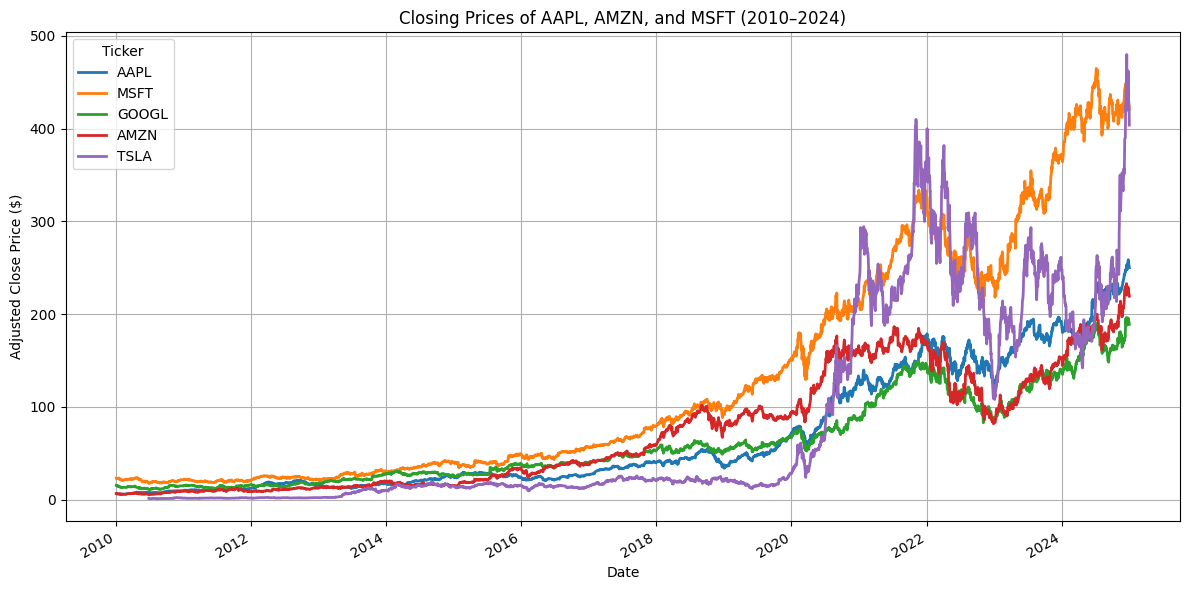

In [15]:
import matplotlib.pyplot as plt

# Suppose your DataFrame is named df
# Extract the 'Close' level
df_close = market_data['Close']  # This will be a (Date x Ticker) DataFrame

df_close[tickers].plot(figsize=(12, 6), linewidth=2)

plt.title("Closing Prices of AAPL, AMZN, and MSFT (2010–2024)")
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price ($)")
plt.grid(True)
plt.legend(title="Ticker")
plt.tight_layout()
plt.show()